# Preparation

In [846]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, mode
import numpy as np

In [847]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

sns.set_theme(style='white', font_scale=1.2)
TIP_colors =  ["#1B4355", "#CB7A2C", "#7A8F50"]
sns.set_palette(TIP_colors)

# HTML("<div style='column-count: 2;'>{}</div>".format(code))
sns.color_palette(TIP_colors)

[(0.10588235294117647, 0.2627450980392157, 0.3333333333333333),
 (0.796078431372549, 0.47843137254901963, 0.17254901960784313),
 (0.47843137254901963, 0.5607843137254902, 0.3137254901960784)]

## Data Cleaning of TIP_StudentData and Demographic Descriptive Analysis

In [848]:
df_student = pd.read_csv('TIP_StudentData.csv', parse_dates=['DOB', 'GraduatedDate', 'InterviewedDate','StartDate','EndDate'])
df_race = pd.read_csv('tip_cohort_demographics_rg.csv')[['tip_id', 'census_tract', 'gender', 'race']]

In [849]:
# define status
def status(row):
    if not pd.isnull(row['GraduatedDate']):
        return 'Graduated'
    elif (not pd.isnull(row['StartDate'])) & (not pd.isnull(row['EndDate'])) & ((row['EndDate'] - row['StartDate']).days < 78):
        return 'Non Graduated'
    elif (not pd.isnull(row['InterviewedDate'])) & ((pd.isnull(row['EndDate'])) or (row['EndDate'] - row['InterviewedDate']).days < 78):
        return 'Interviewed'
    else:
        return 'None'
    
df_student['Status'] = df_student.apply(status, axis=1)

In [850]:
# ensure datetime
for c in ["DOB", "StartDate", "InterviewedDate"]:
    if c in df_student.columns:
        df_student[c] = pd.to_datetime(df_student[c], errors="coerce")

# calculate age based on status
age_from_start = (df_student["StartDate"] - df_student["DOB"]).dt.days / 365.25
age_from_interview = (df_student["InterviewedDate"] - df_student["DOB"]).dt.days / 365.25

df_student["age"] = np.select(
    [
        df_student["Status"].isin(["Graduated", "Non Graduated"]),
        df_student["Status"].eq("Interviewed"),
    ],
    [
        np.floor(age_from_start),
        np.floor(age_from_interview),
    ],
    default=np.nan
)

# pre/post 2022 cohort based on StartDate
cutoff = pd.Timestamp("2022-01-01")
df_student["cohort_2022"] = np.where(
    df_student["StartDate"].notna(),
    np.where(df_student["StartDate"] >= cutoff, 2, 1),
    "N/A"
)

# start year
df_student["StartYear"] = df_student["StartDate"].dt.year

# drop DOB
df_student = df_student.drop(columns=["DOB"], errors="ignore")

In [851]:
df_not_none = df_student[df_student['Status'] != 'None'].copy()

In [852]:
df = pd.merge(
    df_not_none,
    df_race,
    on='tip_id',
    how='left'
)

In [853]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
Name: count, dtype: int64

In [854]:
df['StartYear'] = df.apply(lambda x: int(x['StartDate'].year) if not pd.isnull(x['StartDate']) else int(x['InterviewedDate'].year), axis=1)

In [855]:
df_grad = df[df["Status"] == "Graduated"].copy()
df_non_grad = df[df["Status"] == "Non Graduated"].copy()

cols_to_check = ["gender", "race"]

for name, target_df in [("Graduated", df_grad), ("Non Graduated", df_non_grad)]:
    print("\n" + "=" * 30)
    print(f"{name}: ")
    print("=" * 30)

    # --- gender/race distribution (drop NaN) ---
    for col in cols_to_check:
        print(f"\n--- {col} (NaN dropped) ---")
        s = target_df[col].dropna()  # drop NaN for both counts + percentages

        counts = s.value_counts()
        percent = s.value_counts(normalize=True) * 100

        dist_df = pd.DataFrame({"Count": counts, "Percentage (%)": percent.round(2)})
        print(dist_df)

    # --- age stats (mean/median) ---
    print("\n--- age stats (mean/median, NaN dropped) ---")
    age_s = pd.to_numeric(target_df["age"], errors="coerce").dropna()
    age_stats = pd.Series(
        {
            "N (non-missing)": int(age_s.shape[0]),
            "Mean": round(age_s.mean(), 2) if age_s.shape[0] else np.nan,
            "Median": round(age_s.median(), 2) if age_s.shape[0] else np.nan,
        }
    )
    print(age_stats)


Graduated: 

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      661           90.18
Female     72            9.82

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    651           89.67
White     73           10.06
Other      2            0.28

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    759.00
Mean                28.33
Median              27.00
dtype: float64

Non Graduated: 

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      607           90.87
Female     61            9.13

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    614           92.19
White     50            7.51
Other      2            0.30

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    703.00
Mean                26.69
Median              25.00
dtype: float64


In [856]:
max_date = '2026-02-14'

def valid_years(row):
    if not pd.isnull(row['GraduatedDate']):
        return (pd.to_datetime(max_date) - row['GraduatedDate']).days / 365.25
    elif not pd.isnull(row['EndDate']):
        return (pd.to_datetime(max_date) - row['EndDate']).days / 365.25
    elif not pd.isnull(row['StartDate']):
        return (pd.to_datetime(max_date) - row['StartDate']).days / 365.25
    elif not pd.isnull(row['InterviewedDate']):
        return (pd.to_datetime(max_date) - row['InterviewedDate']).days / 365.25
    else:
        return None

df['ValidYears'] = df.apply(valid_years, axis=1)
df.sample(10)

,tip_id,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,age,cohort_2022,StartYear,census_tract,gender,race,ValidYears
512,665,2018-02-23,NaT,2017-12-11,2018-02-23,No,Introduction to Masonry,2018-07-12,Graduated,28.0,1,2017,4.212980e+10,Male,White,7.975359
926,1202,2020-12-04,2020-09-18,2020-09-28,2020-12-04,Yes,Introduction to Masonry,2020-09-18,Graduated,28.0,1,2020,4.200313e+10,Male,Black,5.196441
1811,2104,NaT,2024-06-26,NaT,NaT,No,Introduction to Masonry,2024-06-26,Interviewed,30.0,N/A,2024,4.200311e+10,Male,Black,1.637235
1586,1874,NaT,2023-09-20,2023-09-25,2023-11-20,No,Introduction to Masonry,2023-09-20,Non Graduated,29.0,2,2023,4.200355e+10,Male,Black,2.236824
1961,2260,NaT,2024-12-05,2024-12-16,2024-12-18,No,Introduction to Masonry,2024-12-05,Non Graduated,20.0,2,2024,4.200349e+10,Male,Black,1.158111
1471,1757,NaT,2023-04-20,2023-04-24,2023-04-28,No,Introduction to Masonry,2023-04-20,Non Graduated,18.0,2,2023,4.200357e+10,Male,Black,2.800821
1527,1814,NaT,2023-07-06,2023-07-31,2023-08-01,No,Introduction to Masonry,2023-07-06,Non Graduated,18.0,2,2023,4.200313e+10,Female,Black,2.540726
1423,1709,2023-04-28,2023-02-09,2023-02-13,2023-04-28,No,Introduction to Masonry,2023-02-09,Graduated,31.0,2,2023,4.200355e+10,Male,Black,2.800821
316,379,2016-06-03,NaT,2016-03-21,2016-06-03,No,Introduction to Masonry,2018-07-12,Graduated,27.0,1,2016,4.200347e+10,Male,White,9.700205
158,165,NaT,NaT,2012-03-28,2012-05-03,Yes,Introduction to Masonry,2018-07-12,Non Graduated,26.0,1,2012,4.200313e+10,Male,Black,13.785079


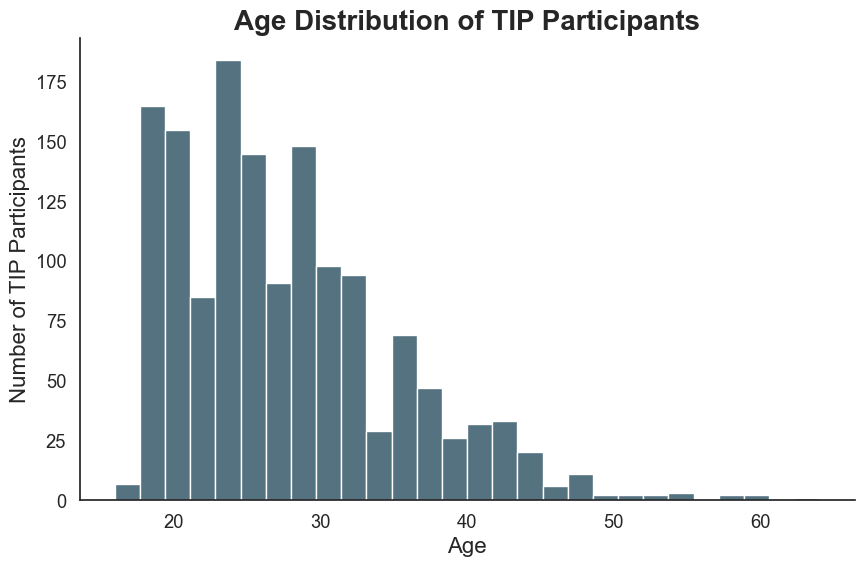

In [857]:
curr_df = df[(df['Status'] == 'Graduated') | (df['Status'] == 'Non Graduated')]
ages = curr_df['age'].dropna()
ages = ages[ages > 5]
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(ages)
sns.despine()
plt.title('Age Distribution of TIP Participants', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Age', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

In [858]:
ages.describe()

count    1459.000000
mean       27.600411
std         7.447026
min        16.000000
25%        22.000000
50%        26.000000
75%        32.000000
max        64.000000
Name: age, dtype: float64

In [859]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
Name: count, dtype: int64

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3716141299.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  graph_counts = df.groupby(['StartYear', 'Status']).size().unstack(fill_value=0)


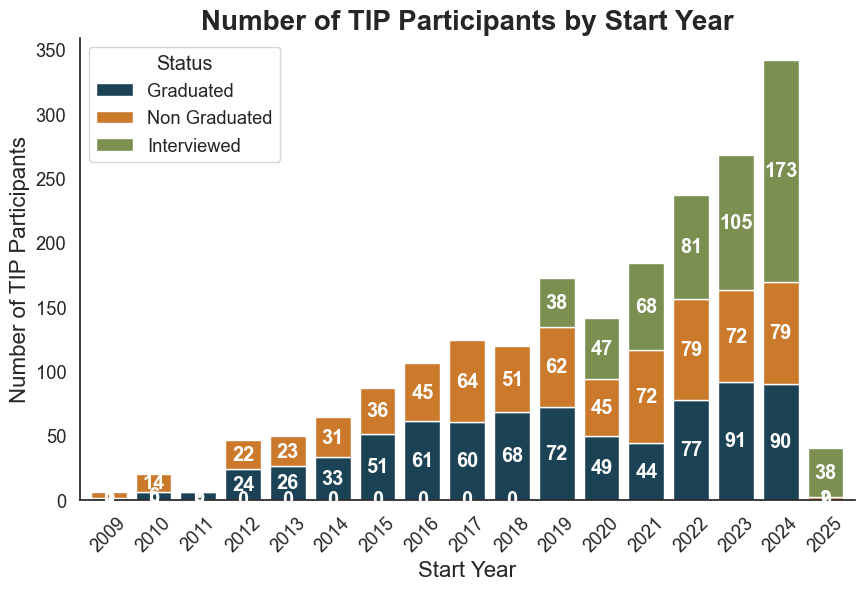

In [860]:
fig, ax = plt.subplots(figsize=(10, 6))

status_order = ["Graduated", "Non Graduated", "Interviewed"]
df['Status'] = pd.Categorical(df['Status'], categories=status_order, ordered=True)

graph_counts = df.groupby(['StartYear', 'Status']).size().unstack(fill_value=0) 
graph_counts.plot(kind='bar', stacked=True, ax=ax, width=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontweight='bold')

sns.despine()
plt.xticks(rotation=45)
plt.title('Number of TIP Participants by Start Year', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

## Data Cleaning of TIP_MergedSentencingData and Offense Descriptive Analysis

In [861]:
df_convictions = pd.read_csv('TIP_MergedSentencingData.csv', parse_dates=['DOF', 'DOS', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate'])
df_convictions = df_convictions[df_convictions['offense_indicator'] == 1]
df_convictions['OffenseBeforeStart'] = df_convictions.apply(lambda x: x['DOS'] < x['StartDate'] if not pd.isnull(x['StartDate']) else (x['DOS'] < x['InterviewedDate'] if not pd.isnull(x['InterviewedDate']) else False), axis=1)

In [862]:
df['OffenseBeforeStart'] = df['tip_id'].apply(lambda x: x in df_convictions[df_convictions['OffenseBeforeStart'] == True]['tip_id'].unique())

In [863]:
df_convictions.head()

,tip_id,DOB,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,DOF,DOS,OGS,INCMIN,PCS_OFF_ID,YearsSinceTIP,offense_indicator,OffenseBeforeStart
0,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,9.0,NaN,1068451.0,-2.505185,1,True
1,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,3.0,NaN,1068451.0,-2.505185,1,True
2,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,10.0,NaN,1068451.0,-2.505185,1,True
3,2,1997-01-27,NaT,NaT,2018-07-12,NaT,No,Introduction to Masonry,2018-07-11,2017-05-02,2018-05-22,9.0,NaN,1041834.0,-1.193727,1,True
4,2,1997-01-27,NaT,NaT,2018-07-12,NaT,No,Introduction to Masonry,2018-07-11,2017-05-02,2018-05-22,1.0,0.131579,1041834.0,-1.193727,1,True


In [864]:
df.head()

,tip_id,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,age,cohort_2022,StartYear,census_tract,gender,race,ValidYears,OffenseBeforeStart
0,1,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,Non Graduated,25.0,1,2018,4.200356e+10,Male,Black,7.540041,True
1,4,2013-10-16,NaT,2013-08-12,2013-10-16,NaN,Introduction to Masonry,2018-07-12,Graduated,30.0,1,2013,4.200313e+10,Male,Black,12.331280,False
2,5,2011-02-04,NaT,2010-11-29,2011-02-04,NaN,Introduction to Masonry,2018-07-12,Graduated,22.0,1,2010,NaN,NaN,NaN,15.028063,False
3,6,NaT,NaT,2013-07-24,2013-09-06,NaN,Introduction to Masonry,2018-07-12,Non Graduated,28.0,1,2013,4.212981e+10,Male,Black,12.440794,False
4,7,NaT,NaT,2013-08-19,2013-08-27,NaN,Introduction to Masonry,2018-07-12,Non Graduated,23.0,1,2013,4.211102e+10,Male,Black,12.468172,False


In [865]:
d = df[df["Status"].isin(["Graduated", "Non Graduated"])].copy()

# make sure it's boolean (handles True/False, "True"/"False", 1/0)
d["OffenseBeforeStart"] = d["OffenseBeforeStart"].map(
    lambda x: True if x is True or x == 1 or str(x).strip().lower() == "true"
    else False if x is False or x == 0 or str(x).strip().lower() == "false"
    else np.nan
)

summary = (
    d.groupby("Status")["OffenseBeforeStart"]
     .agg(
         n_total=lambda s: s.notna().sum(),
         n_true=lambda s: (s == True).sum()
     )
     .reset_index()
)

summary["pct_true"] = (summary["n_true"] / summary["n_total"] * 100).round(2)

print(summary)

          Status  n_total  n_true  pct_true
0      Graduated      759     296     39.00
1  Non Graduated      703     273     38.83
2    Interviewed        0       0       NaN


C:\Users\13429\AppData\Local\Temp\ipykernel_27468\2541622933.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby("Status")["OffenseBeforeStart"]


C:\Users\13429\AppData\Local\Temp\ipykernel_27468\1547725093.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = grouped_df.groupby(['StartYear', 'Status'])['OffenseBeforeStart'].mean().reset_index()
C:\Users\13429\AppData\Local\Temp\ipykernel_27468\1547725093.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for status, subset in grouped_df.groupby('Status'):


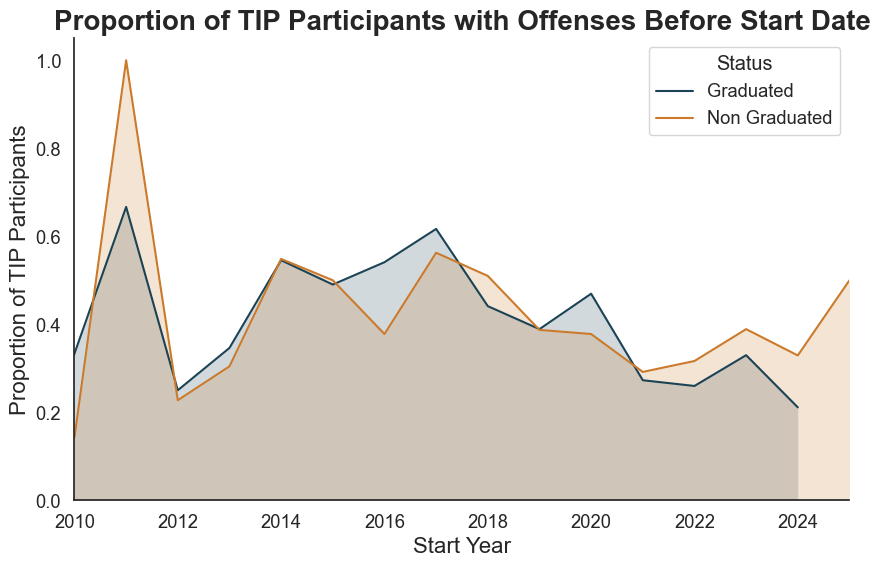

In [866]:
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df = df[df['Status'] != 'Interviewed'].copy()
grouped_df['Status'] = pd.Categorical(grouped_df['Status'], categories=["Graduated", "Non Graduated"], ordered=True)

grouped_df = grouped_df.groupby(['StartYear', 'Status'])['OffenseBeforeStart'].mean().reset_index()
sns.lineplot(
    data=grouped_df,
    x='StartYear',
    y='OffenseBeforeStart',
    hue='Status',
    ax=ax
)
for status, subset in grouped_df.groupby('Status'):
    ax.fill_between(
        subset['StartYear'], subset['OffenseBeforeStart'], 0, alpha=0.2  
    )

sns.despine()

plt.title('Proportion of TIP Participants with Offenses Before Start Date', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Proportion of TIP Participants', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.xlim(2010, 2025)
plt.show()

## Data Cleaning of arrest_data and Arrests Descriptive Analysis

In [867]:
df_arrests = pd.read_csv('arrest_data.csv', parse_dates=['ArrestDate', 'StartDate', 'EndDate', 'InterviewedDate', 'GraduatedDate'])
df_arrests['ArrestBeforeStart'] = df_arrests.apply(lambda x: x['ArrestDate'] < x['StartDate'] if not pd.isnull(x['StartDate']) else (x['ArrestDate'] < x['InterviewedDate'] if not pd.isnull(x['InterviewedDate']) else False), axis=1)

In [868]:
df['ArrestBeforeStart'] = df['tip_id'].apply(lambda x: x in df_arrests[df_arrests['ArrestBeforeStart'] == True]['tip_id'].unique())

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3009478391.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = grouped_df.groupby(['StartYear', 'Status'])['ArrestBeforeStart'].mean().reset_index()
C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3009478391.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for status, subset in grouped_df.groupby('Status'):


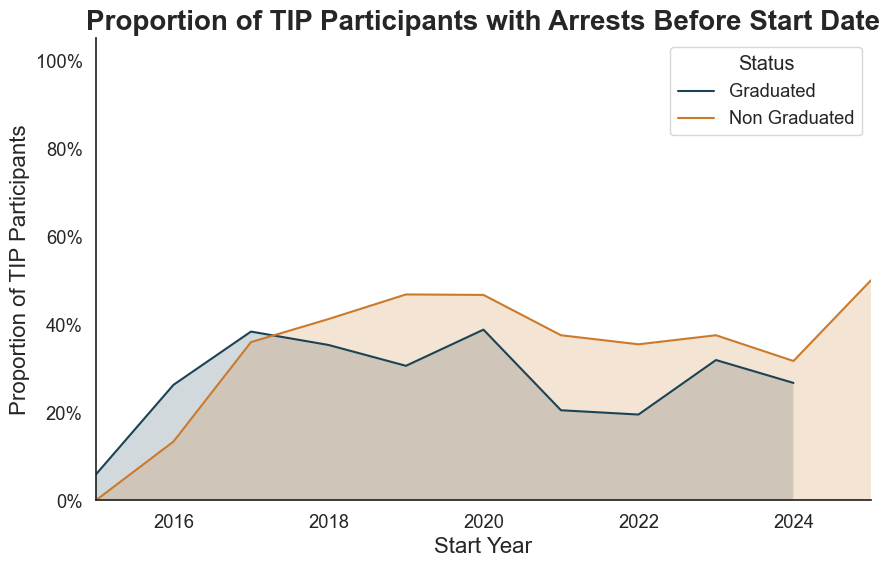

In [869]:
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df = df[df['Status'] != 'Interviewed'].copy()
grouped_df['Status'] = pd.Categorical(grouped_df['Status'], categories=["Graduated", "Non Graduated"], ordered=True)

grouped_df = grouped_df.groupby(['StartYear', 'Status'])['ArrestBeforeStart'].mean().reset_index()
sns.lineplot(
    data=grouped_df,
    x='StartYear',
    y='ArrestBeforeStart',
    hue='Status',
    ax=ax
)
for status, subset in grouped_df.groupby('Status'):
    ax.fill_between(
        subset['StartYear'], subset['ArrestBeforeStart'], 0, alpha=0.2  
    )

sns.despine()

ax.yaxis.set_major_formatter('{:.0%}'.format)
plt.title('Proportion of TIP Participants with Arrests Before Start Date', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Proportion of TIP Participants', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.xlim(2015, 2025)
plt.show()

## OGS

In [870]:
df_convictions = pd.merge(
    df_convictions,
    df[['tip_id', 'Status', 'ValidYears']],
    on='tip_id',
    how='left'
)

In [871]:
df_convictions_ogs = df_convictions.dropna(subset=['Status']).copy()
df_convictions_ogs = df_convictions_ogs[df_convictions_ogs['OffenseBeforeStart'] == True]
df_convictions_ogs['StartYear'] = df_convictions_ogs.apply(lambda x: x['StartDate'].year if not pd.isnull(x['StartDate']) else x['InterviewedDate'].year, axis=1)
df_convictions_ogs = df_convictions_ogs[df_convictions_ogs['Status'] != 'Interviewed']
df_convictions_ogs['Status'] = pd.Categorical(df_convictions_ogs['Status'], categories=["Graduated", "Non Graduated"], ordered=True)
df_convictions_ogs['OGS'] = df_convictions_ogs['OGS'].astype(int)

In [872]:
# The records with same tip_id, DOF, OGS, and Status are treated as duplicates
df_convictions_ogs = df_convictions_ogs.drop_duplicates(subset=["tip_id", "DOF", "OGS", "Status"])

ogs_df = pd.DataFrame(df_convictions_ogs.groupby(['OGS', 'Status']).size()).reset_index()
ogs_df.columns = ['OGS', 'Status', 'Count']
ogs_df['Percentage'] = ogs_df['Count'] / ogs_df['Count'].sum()
ogs_df = ogs_df.pivot(index='OGS', columns='Status', values=['Percentage', 'Count'])
ogs_df.columns = ['Graduated_Percentage', 'Non Graduated_Percentage', 'Graduated_Count', 'Non Graduated_Count']
ogs_df = ogs_df.reset_index()

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\1743254842.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ogs_df = pd.DataFrame(df_convictions_ogs.groupby(['OGS', 'Status']).size()).reset_index()


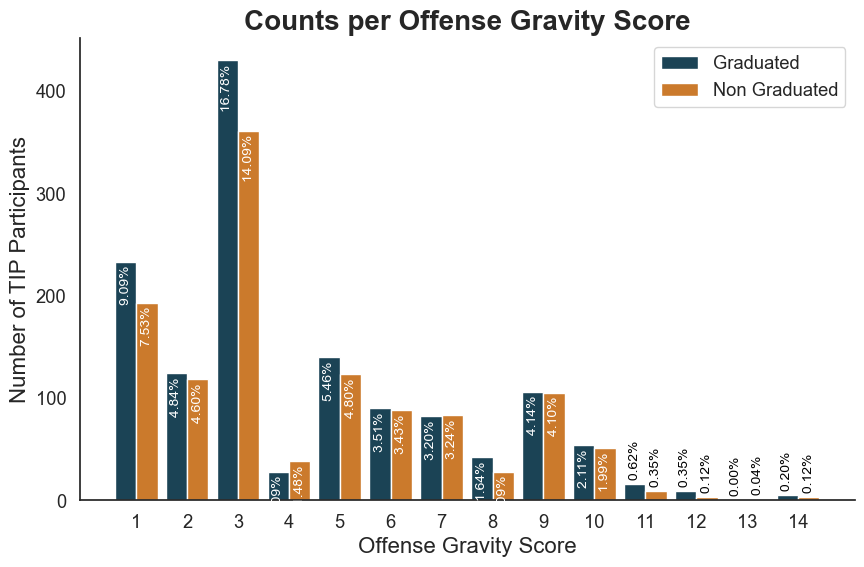

In [873]:
fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(ogs_df))

bar_width = 0.42

plt.bar(
    x_indexes - bar_width / 2,
    ogs_df['Graduated_Count'],
    width=bar_width,
    label='Graduated',
    color=TIP_colors[0]
)

plt.bar(
    x_indexes + bar_width / 2,
    ogs_df['Non Graduated_Count'],
    width=bar_width,
    label='Non Graduated',
    color=TIP_colors[1]
)

for i, (x, y, upper, y2, upper2) in enumerate(zip(x_indexes, ogs_df['Graduated_Percentage'], ogs_df['Graduated_Count'], ogs_df['Non Graduated_Percentage'], ogs_df['Non Graduated_Count'])):
    if i >= 10:
        continue
    plt.text(x - bar_width / 2, upper + 0.01, f'{y:.2%} ', ha='center', va='top', fontsize=10, rotation=90, color='white')
    plt.text(x + bar_width / 2, upper2 + 0.01, f'{y2:.2%} ', ha='center', va='top', fontsize=10, rotation=90, color='white')

for i, (x, y, upper, y2, upper2) in enumerate(zip(x_indexes, ogs_df['Graduated_Percentage'], ogs_df['Graduated_Count'], ogs_df['Non Graduated_Percentage'], ogs_df['Non Graduated_Count'])):
    if i < 10:
        continue
    plt.text(x - bar_width / 2, upper + 0.01, f' {y:.2%}', ha='center', va='bottom', fontsize=10, rotation=90, color='black')
    plt.text(x + bar_width / 2, upper2 + 0.01, f' {y2:.2%}', ha='center', va='bottom', fontsize=10, rotation=90, color='black')

sns.despine()

plt.xticks(ticks=x_indexes, labels=ogs_df['OGS'], rotation=0)
plt.legend()
plt.title('Counts per Offense Gravity Score', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Offense Gravity Score', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

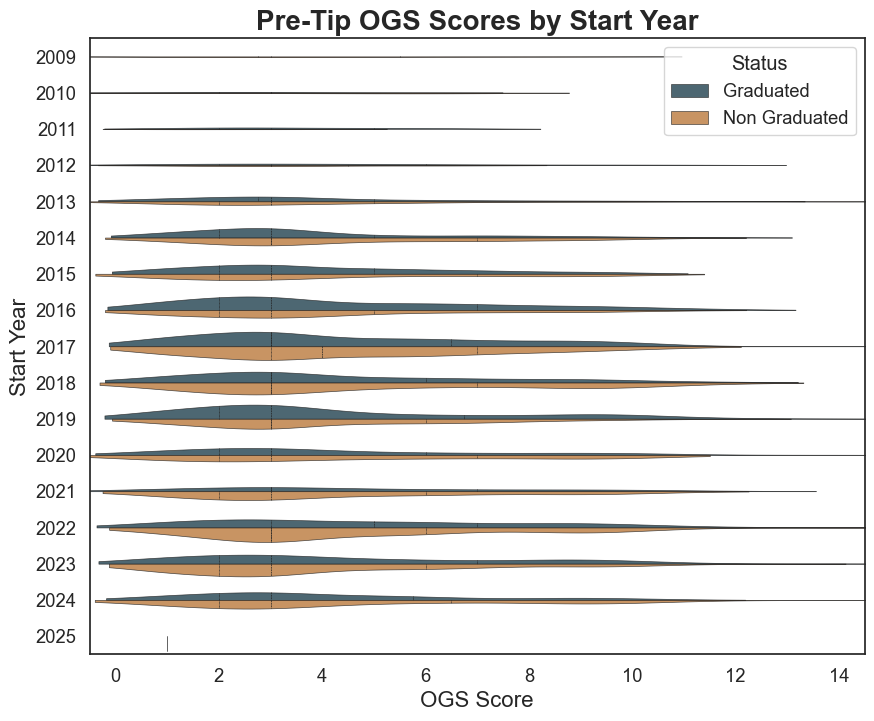

In [874]:
plt.figure(figsize=(10, 8))

sns.violinplot(
    data = df_convictions_ogs,
    y='StartYear',
    x='OGS',
    hue='Status',
    split=True,
    inner='quart',
    orient='h',
    saturation=0.8,
    dodge=True,
    cut=1.1,
    density_norm='count',
    linewidth=0.5,
    alpha=0.8
)

plt.title('Pre-Tip OGS Scores by Start Year', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.ylabel('Start Year', fontdict={'fontsize': 16})
plt.xlabel('OGS Score', fontdict={'fontsize': 16})
plt.xlim(-0.5, 14.5)
plt.show()

## Criminal Justice Interactions

In [875]:
def years_since_TIP(row):
    val = 0
    dof = row['DOF']
    if not pd.isnull(row['StartDate']):
        start = row['StartDate']
    else:
        start = row['InterviewedDate']
    if not pd.isnull(row['GraduatedDate']):
        end = row['GraduatedDate']
    else:
        end = row['EndDate']

    if pd.isnull(start) and pd.isnull(end):
        return None

    if dof > start:
        val = (dof - end).days/365.2425
    elif dof < start:
        val = -(start - dof).days/365.2425
    return val

df_convictions['YearsSinceTIP'] = df_convictions.apply(years_since_TIP, axis=1)

In [876]:
df_arrests = pd.merge(
    df_arrests,
    df[['tip_id', 'Status', 'ValidYears']],
    on='tip_id',
    how='left'
)

In [877]:
df_arrests['DOF'] = df_arrests['ArrestDate']
df_arrests['YearsSinceTIP'] = df_arrests.apply(years_since_TIP, axis=1)

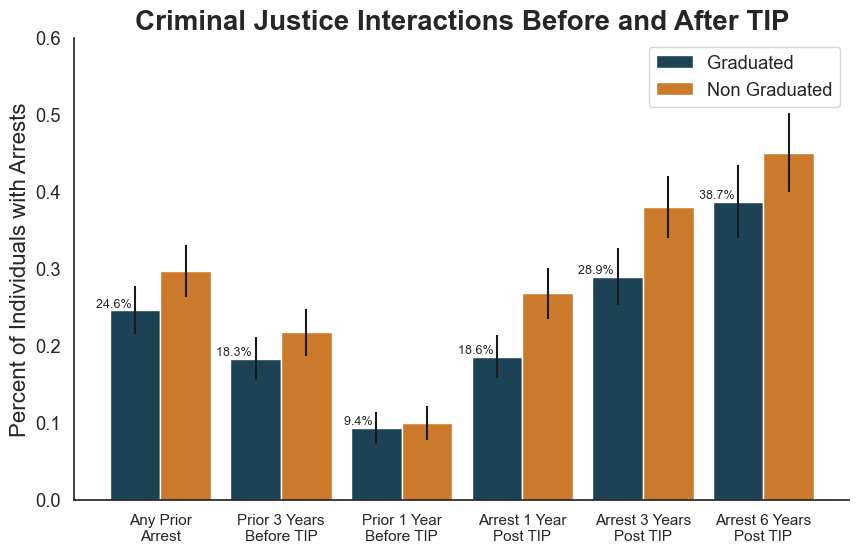

In [878]:
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Graduated')].copy()
    curr_non_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df[df['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Graduated') & (df_arrests['ValidYears'] > i)].copy()
    curr_non_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Non Graduated') & (df_arrests['ValidYears'] > i)].copy()
    curr_interviewed = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Interviewed') & (df_arrests['ValidYears'] > i)].copy()

    graduate_pop_size = df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 6)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Arrest", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Arrest 1 Year Post TIP", 
    "Arrest 3 Years Post TIP", 
    "Arrest 6 Years Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nArrest", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Arrest 1 Year\nPost TIP", 
    "Arrest 3 Years\nPost TIP", 
    "Arrest 6 Years\nPost TIP"
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Arrests', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


In [879]:
df_2022 = df[df['StartYear'] >= 2022].copy()

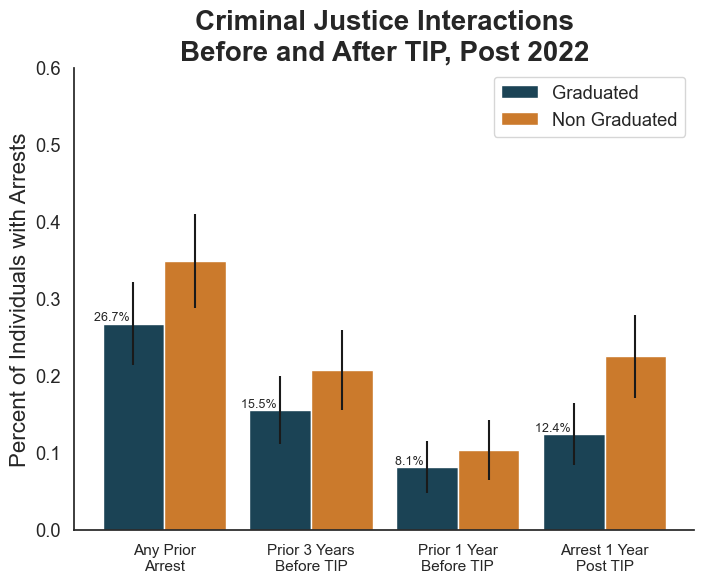

In [880]:
df_arrests_2022 = df_arrests[df_arrests['tip_id'].isin(df_2022['tip_id'])]
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Graduated')].copy()
    curr_non_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Graduated') & (df_arrests_2022['ValidYears'] > i)].copy()
    curr_non_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Non Graduated') & (df_arrests_2022['ValidYears'] > i)].copy()
    curr_interviewed = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Interviewed') & (df_arrests_2022['ValidYears'] > i)].copy()

    graduate_pop_size = df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Interviewed')].tip_id.nunique()))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Arrest", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Arrest 1 Year Post TIP", 
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(8, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nArrest", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Arrest 1 Year\nPost TIP", 
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions\nBefore and After TIP, Post 2022', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Arrests', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


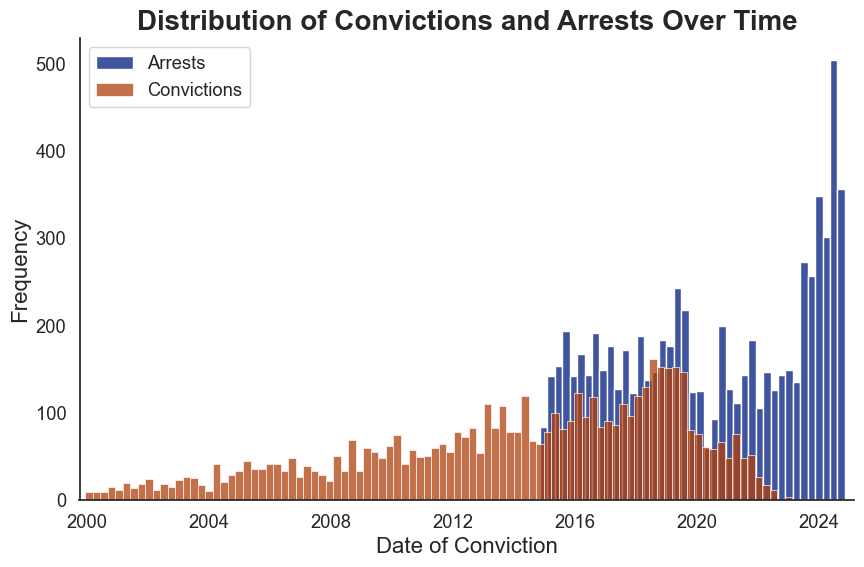

In [881]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    df_arrests['DOF'],
    binwidth=90,
    color=sns.color_palette('dark')[0]
)

sns.histplot(
    df_convictions['DOF'],
    binwidth=90,
    color=sns.color_palette('dark')[1]
)

sns.despine()

plt.title('Distribution of Convictions and Arrests Over Time', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlim(pd.Timestamp('1999-10-01'), pd.Timestamp('2025-02-28'))
plt.xlabel('Date of Conviction', fontdict={'fontsize': 16})
plt.ylabel('Frequency', fontdict={'fontsize': 16})
plt.legend(['Arrests', 'Convictions'])
plt.show()


## Data Cleaning of tip_cohort_uiearnings and Employment Descriptive Analysis

In [882]:
df_earnings = pd.read_csv('tip_cohort_uiearnings.csv')
df_inflation = pd.read_csv('inflation_data.csv')

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3366414065.py:1: DtypeWarning: Columns (3,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_earnings = pd.read_csv('tip_cohort_uiearnings.csv')


In [883]:
# process quarter to datetime
q_str = df_earnings["quarter"].astype(str).str.strip()

df_earnings["year"] = q_str.str[:4].astype(int)
df_earnings["qnum"] = q_str.str[-1].astype(int)  # 1-4

# map to fiscal quarter end month/day
# Q1 -> 12/31 (same year)
# Q2 -> 03/31 (next year)
# Q3 -> 06/30 (next year)
# Q4 -> 09/30 (next year)
month_map = {1: 12, 2: 3, 3: 6, 4: 9}
day_map   = {1: 31, 2: 31, 3: 30, 4: 30}

df_earnings["fiscal_end_year"] = df_earnings["year"]
df_earnings["fiscal_end_month"] = df_earnings["qnum"].map(month_map)
df_earnings["fiscal_end_day"] = df_earnings["qnum"].map(day_map)

df_earnings["year_quarter_dt"] = pd.to_datetime(
    dict(
        year=df_earnings["fiscal_end_year"],
        month=df_earnings["fiscal_end_month"],
        day=df_earnings["fiscal_end_day"],
    ),
    errors="coerce",
)

df_earnings["year_month"] = df_earnings["year_quarter_dt"].dt.to_period("M")
df_earnings.drop(columns=["Unnamed: 0", "qnum", "fiscal_end_year", "fiscal_end_month", "fiscal_end_day"], errors="ignore", inplace=True)

In [884]:
df_earnings.head()

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022,year,year_quarter_dt,year_month
0,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants,2018,2018-03-31,2018-03
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-09-30,2017-09
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-09-30,2017-09
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-12-31,2018-12
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-12-31,2018-12


In [885]:
# adjust income data for inflation
df_inflation.drop(columns=['HALF1', 'HALF2'], inplace=True)
df_inflation = df_inflation.melt(id_vars='Year', var_name='Month', value_name='CPI')

month_map = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
             'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
df_inflation["year_month"] = (
    df_inflation["Year"].astype(str) + "-" + df_inflation["Month"].map(month_map)
)
# sort by date to ensure that the latest CPI value is at the end of the DataFrame
df_inflation = df_inflation.sort_values("year_month").reset_index(drop=True)
latest_cpi = df_inflation.loc[df_inflation["year_month"] == "2025-12", "CPI"].iloc[0]

df_earnings["year_month"] = df_earnings["year_month"].astype(str)

cpi_map = df_inflation.drop_duplicates("year_month").set_index("year_month")["CPI"]
df_earnings["CPI"] = df_earnings["year_month"].map(cpi_map)

df_earnings["adjusted_earnings"] = df_earnings["earnings"] * (latest_cpi / df_earnings["CPI"])

In [886]:
df_earnings.head()

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022,year,year_quarter_dt,year_month,CPI,adjusted_earnings
0,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants,2018,2018-03-31,2018-03,249.554,1862.095723
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-09-30,2017-09,246.819,4131.764321
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-09-30,2017-09,246.819,6110.337194
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-12-31,2018-12,251.233,2461.042268
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-12-31,2018-12,251.233,9241.807048


In [887]:
df_e = df_earnings.merge(
    df[["tip_id", "StartDate", "StartYear", "Status"]],
    on="tip_id",
    how="left"
)

df_e["distance_from_TIP"] = df_e["year"] - df_e["StartYear"]

# pre/post per quarter
# StartDate <= year_quarter_dt -> post
# StartDate > year_quarter_dt -> pre
df_e["pre_post_q"] = np.where(
    df_e["StartDate"].isna() | df_e["year_quarter_dt"].isna(),
    "N/A",
    np.where(df_e["StartDate"] < df_e["year_quarter_dt"], "post", "pre")
)

# mean annual earnings
tmp = (
    df_e[df_e["pre_post_q"].isin(["pre", "post"])]
    .groupby(["tip_id", "pre_post_q"])["adjusted_earnings"]
    .mean()
    .unstack("pre_post_q")
)
tmp["earnings_pre"] = tmp["pre"] * 4
tmp["earnings_post"] = tmp["post"] * 4

# change metrics
tmp["abs_change"] = tmp["earnings_post"] - tmp["earnings_pre"]
tmp["per_change"] = (tmp["earnings_post"] - tmp["earnings_pre"]) / tmp["earnings_pre"]

tmp.loc[(tmp["earnings_pre"].isna()) | (tmp["earnings_pre"] == 0), "per_change"] = np.nan

# student-level results
earn_change = tmp[["earnings_pre", "earnings_post", "abs_change", "per_change"]].reset_index()

# merge back to df (one row per tip_id)
df = df.merge(earn_change, on="tip_id", how="left")

In [888]:
earn_change.head()

pre_post_q,tip_id,earnings_pre,earnings_post,abs_change,per_change
0,1,274.696002,35278.655921,35003.959919,127.427992
1,4,NaN,11318.504487,NaN,NaN
2,6,NaN,167.643625,NaN,NaN
3,7,NaN,2325.515464,NaN,NaN
4,8,NaN,7114.310716,NaN,NaN


In [889]:
df.columns

Index(['tip_id', 'GraduatedDate', 'InterviewedDate', 'StartDate', 'EndDate',
       'DriversLicense', 'Course', 'CreatedDate', 'Status', 'age',
       'cohort_2022', 'StartYear', 'census_tract', 'gender', 'race',
       'ValidYears', 'OffenseBeforeStart', 'ArrestBeforeStart', 'earnings_pre',
       'earnings_post', 'abs_change', 'per_change'],
      dtype='object')

In [890]:
# define employment status based on whether tip_id exists in df_earnings
def has_employment(tip_id):
    return tip_id in df_earnings['tip_id'].unique()

df['has_employment'] = df['tip_id'].apply(has_employment)

In [891]:
df_grad = df[df["Status"] == "Graduated"].copy()
df_non_grad = df[df["Status"] == "Non Graduated"].copy()
df_grad.head()

,tip_id,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,age,...,gender,race,ValidYears,OffenseBeforeStart,ArrestBeforeStart,earnings_pre,earnings_post,abs_change,per_change,has_employment
1,4,2013-10-16,NaT,2013-08-12,2013-10-16,NaN,Introduction to Masonry,2018-07-12,Graduated,30.0,...,Male,Black,12.331280,False,False,NaN,11318.504487,NaN,NaN,True
2,5,2011-02-04,NaT,2010-11-29,2011-02-04,NaN,Introduction to Masonry,2018-07-12,Graduated,22.0,...,NaN,NaN,15.028063,False,False,NaN,NaN,NaN,NaN,False
5,8,2012-04-12,NaT,2012-02-13,2012-04-12,NaN,Introduction to Masonry,2018-07-12,Graduated,22.0,...,Male,Black,13.842574,False,False,NaN,7114.310716,NaN,NaN,True
7,10,2018-01-02,NaT,2018-01-01,2018-01-02,NaN,Introduction to Masonry,2018-07-12,Graduated,28.0,...,Male,Black,8.117728,True,False,186.434869,867.026467,680.591598,3.65056,True
8,11,2013-05-10,NaT,2013-02-27,2013-05-10,NaN,Introduction to Masonry,2018-07-12,Graduated,41.0,...,NaN,NaN,12.766598,False,False,NaN,NaN,NaN,NaN,False


In [892]:
for name, target_df in [("Graduated", df_grad), ("Non Graduated", df_non_grad)]:
    print("\n" + "=" * 30)
    print(f"{name}: pre-TIP annual earnings (earnings_pre)")
    print("=" * 30)

    s = pd.to_numeric(target_df["earnings_pre"], errors="coerce").dropna()

    stats = pd.Series(
        {
            "N (non-missing)": int(s.shape[0]),
            "Mean": round(s.mean(), 2) if s.shape[0] else np.nan,
            "Median": round(s.median(), 2) if s.shape[0] else np.nan,
        }
    )
    print(stats)


Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     493.00
Mean               6728.23
Median             4087.71
dtype: float64

Non Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     476.00
Mean               4726.83
Median             2499.37
dtype: float64


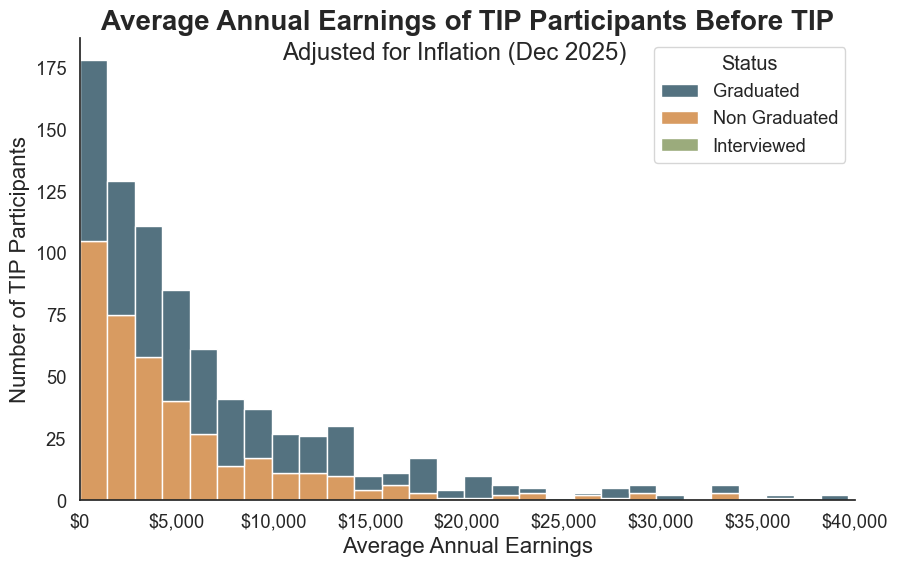

In [893]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        (df["Status"].isin(["Graduated", "Non Graduated"])) &
        (df["earnings_pre"] > 0) & (df["earnings_pre"] < 40000)
    ],
    x="earnings_pre",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of TIP Participants Before TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

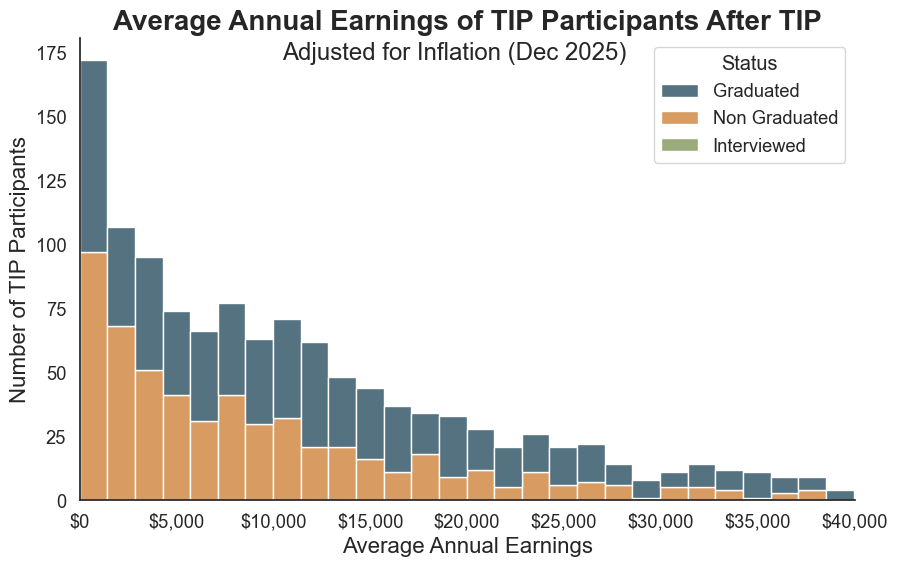

In [894]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        (df["Status"].isin(["Graduated", "Non Graduated"])) &
        (df["earnings_post"] > 0) & (df["earnings_post"] < 40000)
    ],
    x="earnings_post",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of TIP Participants After TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

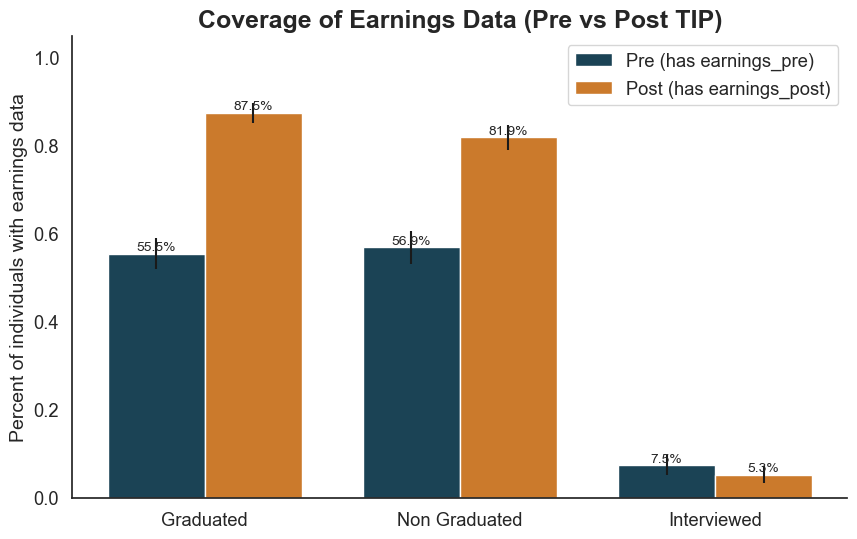

In [895]:
status_order = ["Graduated", "Non Graduated", "Interviewed"]

def has_pre(s):
    return s.notna() & (s > 0)

def has_post(s):
    return s.notna() & (s > 0)

rows = []
z = 1.96

for status in status_order:
    g = df[df["Status"] == status]

    n = g["tip_id"].nunique()

    pre_num = has_pre(pd.to_numeric(g["earnings_pre"], errors="coerce")).sum()
    post_num = has_post(pd.to_numeric(g["earnings_post"], errors="coerce")).sum()

    pre_p = pre_num / n if n > 0 else np.nan
    post_p = post_num / n if n > 0 else np.nan

    # 95% CI (normal approx)
    pre_se = np.sqrt(pre_p * (1 - pre_p) / n) if (n > 0 and pd.notna(pre_p)) else np.nan
    post_se = np.sqrt(post_p * (1 - post_p) / n) if (n > 0 and pd.notna(post_p)) else np.nan

    rows.append({
        "Status": status,
        "N": n,

        "Pre": pre_p,
        "Pre_Lower": max(0, pre_p - z * pre_se) if pd.notna(pre_se) else np.nan,
        "Pre_Upper": min(1, pre_p + z * pre_se) if pd.notna(pre_se) else np.nan,

        "Post": post_p,
        "Post_Lower": max(0, post_p - z * post_se) if pd.notna(post_se) else np.nan,
        "Post_Upper": min(1, post_p + z * post_se) if pd.notna(post_se) else np.nan,
    })

cov = pd.DataFrame(rows)
cov["Status"] = pd.Categorical(cov["Status"], categories=status_order, ordered=True)
cov = cov.sort_values("Status").reset_index(drop=True)

# ---- plot: side-by-side bars for Pre vs Post within each Status ----
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(cov))
width = 0.38

pre_err = np.abs(cov[["Pre_Upper", "Pre_Lower"]].T.values - cov["Pre"].values)
post_err = np.abs(cov[["Post_Upper", "Post_Lower"]].T.values - cov["Post"].values)

ax.bar(x - width/2, cov["Pre"], width=width, label="Pre (has earnings_pre)", yerr=pre_err, capsize=0)
ax.bar(x + width/2, cov["Post"], width=width, label="Post (has earnings_post)", yerr=post_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(cov["Status"], rotation=0)

for xi, p in zip(x - width/2, cov["Pre"]):
    ax.text(xi, p, f"{p:.1%}", ha="center", va="bottom", fontsize=10)
for xi, p in zip(x + width/2, cov["Post"]):
    ax.text(xi, p, f"{p:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.ylim(0, 1.05)
plt.ylabel("Percent of individuals with earnings data", fontdict={"fontsize": 14})
plt.title("Coverage of Earnings Data (Pre vs Post TIP)", fontdict={"fontsize": 18, "fontweight": "semibold"})
plt.legend()
plt.show()


In [896]:
df_earnings.columns

Index(['tip_id', 'quarter', 'employer_legal_name', 'earnings', 'naics_code',
       'naics_sector_2017', 'naics_subsector_2017', 'naics_industry_2017',
       'naics_sector_2022', 'naics_subsector_2022', 'naics_industry_2022',
       'year', 'year_quarter_dt', 'year_month', 'CPI', 'adjusted_earnings'],
      dtype='object')

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\1416261255.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pre.groupby(["YearsSinceTIP_int", "Status"])["tip_id"]
C:\Users\13429\AppData\Local\Temp\ipykernel_27468\1416261255.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Status")["tip_id"].nunique()


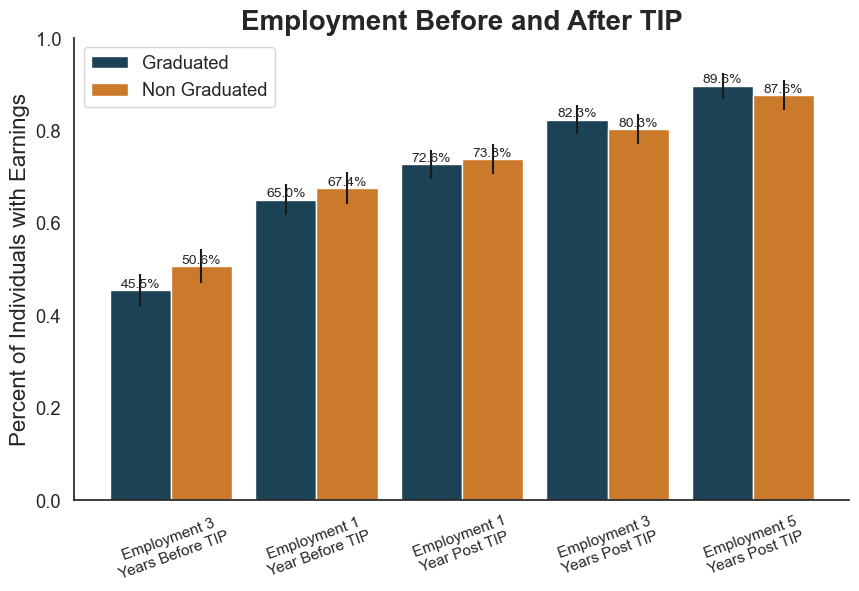

In [897]:
# -----------------------------
# 0) join Status / StartDate / ValidYears onto df_earnings
# -----------------------------
e = df_earnings.merge(
    df[["tip_id", "StartDate", "ValidYears", "Status"]],
    on="tip_id",
    how="left"
)

# keep only Graduated / Non Graduated
e = e[e["Status"].isin(["Graduated", "Non Graduated"])].copy()

# -----------------------------
# 1) YearsSinceTIP (in years) using quarter end date
# -----------------------------
e["YearsSinceTIP"] = (e["year_quarter_dt"] - e["StartDate"]).dt.days / 365.25

# "employment in quarter" indicator: has employer legal name in that quarter
e["employed_quarter"] = e["employer_legal_name"].notna() & (e["employer_legal_name"].astype(str).str.strip() != "")

# integer bin for pre buckets: >0 -> ceil, <0 -> floor, 0 -> 0
y = e["YearsSinceTIP"]
e["YearsSinceTIP_int"] = np.where(y > 0, np.ceil(y), np.where(y < 0, np.floor(y), 0)).astype(int)

# -----------------------------
# 2) PRE: bins -30, -3, -1 (within that 1-year bin)
# -----------------------------
pre_bins = [-30, -3, -1]
pre = e[e["YearsSinceTIP_int"].isin(pre_bins)]

pre_count = (
    pre.groupby(["YearsSinceTIP_int", "Status"])["tip_id"]
    .nunique()
    .unstack("Status", fill_value=0)
    .reset_index()
    .rename(columns={"YearsSinceTIP_int": "YearsSinceTIP"})
)

# denominators for pre: total people per status (from df)
denom_pre = (
    df[df["Status"].isin(["Graduated", "Non Graduated"])]
    .groupby("Status")["tip_id"].nunique()
    .to_dict()
)

# proportions + CI
z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count.get(status, 0) / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,3,5 and require ValidYears > i
# -----------------------------
post_points = [1, 3, 5]
rows = []

for i in post_points:
    cur = e[(e["YearsSinceTIP"] >= 0) & (e["YearsSinceTIP"] < i) & (e["ValidYears"] > i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] > i), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nEmployment",
    -3:  "Employment 3\nYears Before TIP",
    -1:  "Employment 1\nYear Before TIP",
     1:  "Employment 1\nYear Post TIP",
     3:  "Employment 3\nYears Post TIP",
     5:  "Employment 5\nYears Post TIP",
}
order = [-30, -3, -1, 1, 3, 5]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Employment Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Earnings", fontdict={"fontsize": 16})
plt.ylim(0, 1.0)
plt.legend(loc="upper left")
plt.show()


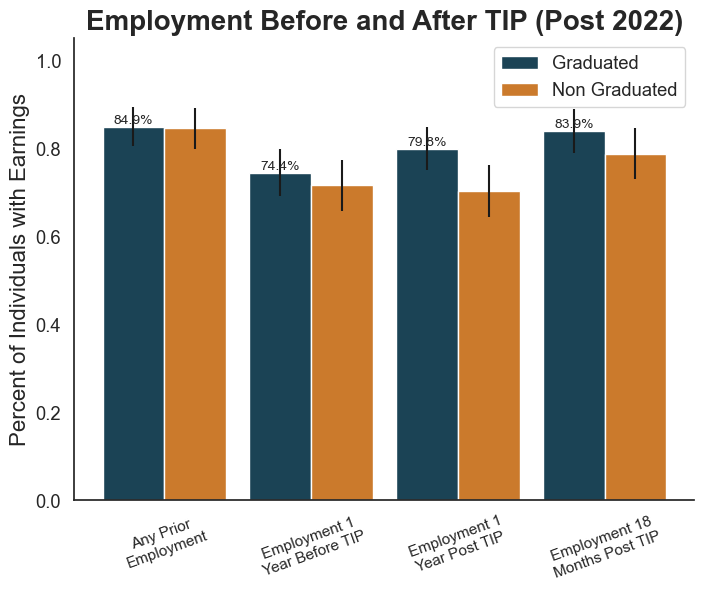

In [898]:
# -----------------------------
# Post-2022 sample
# -----------------------------
cutoff = pd.Timestamp("2022-01-01")

df_2022 = df[df["StartDate"] > cutoff].copy()

e = df_earnings.merge(
    df_2022[["tip_id", "StartDate", "ValidYears", "Status"]],
    on="tip_id",
    how="inner"   # only keep post-2022 people
).copy()

e = e[e["Status"].isin(["Graduated", "Non Graduated"])].copy()

# YearsSinceTIP in years using quarter end date
e["YearsSinceTIP"] = (e["year_quarter_dt"] - e["StartDate"]).dt.days / 365.25

# quarterly earnings presence (employment proxy)
e["employed_quarter"] = e["adjusted_earnings"].notna() & (e["adjusted_earnings"] > 0)

z = 1.96

def pct_ci(num, denom):
    if denom <= 0:
        return 0.0, np.nan, np.nan
    p = num / denom
    se = np.sqrt(p * (1 - p) / denom)
    lower = max(0, p - z * se)
    upper = min(1, p + z * se)
    return p, lower, upper

# -----------------------------
# Define 4 categories
# -----------------------------
categories = [
    ("Any Prior\nEmployment", "any_prior"),
    ("Employment 1\nYear Before TIP", "pre_1y"),
    ("Employment 1\nYear Post TIP", "post_1y"),
    ("Employment 18\nMonths Post TIP", "post_18m"),
]

rows = []
for status in ["Graduated", "Non Graduated"]:
    base_den_any = df_2022[df_2022["Status"] == status]["tip_id"].nunique()

    for label, key in categories:
        # numerator: uniq people with >=1 quarter record in the window
        if key == "any_prior":
            numer = e.loc[
                (e["Status"] == status) & (e["YearsSinceTIP"] < 0) & (e["employed_quarter"]),
                "tip_id"
            ].nunique()
            denom = base_den_any

        elif key == "pre_1y":
            numer = e.loc[
                (e["Status"] == status) & (e["YearsSinceTIP"] >= -1) & (e["YearsSinceTIP"] < 0) & (e["employed_quarter"]),
                "tip_id"
            ].nunique()
            denom = base_den_any

        elif key == "post_1y":
            numer = e.loc[
                (e["Status"] == status) & (e["YearsSinceTIP"] >= 0) & (e["YearsSinceTIP"] < 1) &
                (e["ValidYears"] > 1) & (e["employed_quarter"]),
                "tip_id"
            ].nunique()
            denom = df_2022.loc[
                (df_2022["Status"] == status) & (df_2022["ValidYears"] > 1),
                "tip_id"
            ].nunique()

        elif key == "post_18m":
            numer = e.loc[
                (e["Status"] == status) & (e["YearsSinceTIP"] >= 0) & (e["YearsSinceTIP"] < 1.5) &
                (e["ValidYears"] > 1.5) & (e["employed_quarter"]),
                "tip_id"
            ].nunique()
            denom = df_2022.loc[
                (df_2022["Status"] == status) & (df_2022["ValidYears"] > 1.5),
                "tip_id"
            ].nunique()

        p, lower, upper = pct_ci(numer, denom)

        rows.append({
            "Category": label,
            "Status": status,
            "Percent": p,
            "Lower": lower,
            "Upper": upper
        })

plot_df = pd.DataFrame(rows)
plot_df["Status"] = pd.Categorical(plot_df["Status"], categories=["Graduated", "Non Graduated"], ordered=True)
plot_df["Category"] = pd.Categorical(plot_df["Category"], categories=[c[0] for c in categories], ordered=True)
plot_df = plot_df.sort_values(["Category", "Status"]).reset_index(drop=True)

# reshape for plotting
pivot = plot_df.pivot(index="Category", columns="Status", values="Percent")
upper = plot_df.pivot(index="Category", columns="Status", values="Upper")
lower = plot_df.pivot(index="Category", columns="Status", values="Lower")

grad_err = np.abs(np.vstack([upper["Graduated"].values, lower["Graduated"].values]) - pivot["Graduated"].values)
nongrad_err = np.abs(np.vstack([upper["Non Graduated"].values, lower["Non Graduated"].values]) - pivot["Non Graduated"].values)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(len(pivot.index))
width = 0.42

ax.bar(
    x - width/2,
    pivot["Graduated"].values,
    width=width,
    label="Graduated",
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x + width/2,
    pivot["Non Graduated"].values,
    width=width,
    label="Non Graduated",
    yerr=nongrad_err,
    capsize=0
)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index.tolist(), rotation=20, ha="center", fontsize=11)

# percent labels (like your screenshot: label Graduated only)
for xi, yi in zip(x - width/2, pivot["Graduated"].values):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Employment Before and After TIP (Post 2022)", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Earnings", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()


C:\Users\13429\AppData\Local\Temp\ipykernel_27468\4112218441.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  e.groupby(["naics_subsector_2017", "Status"])["tip_id"]


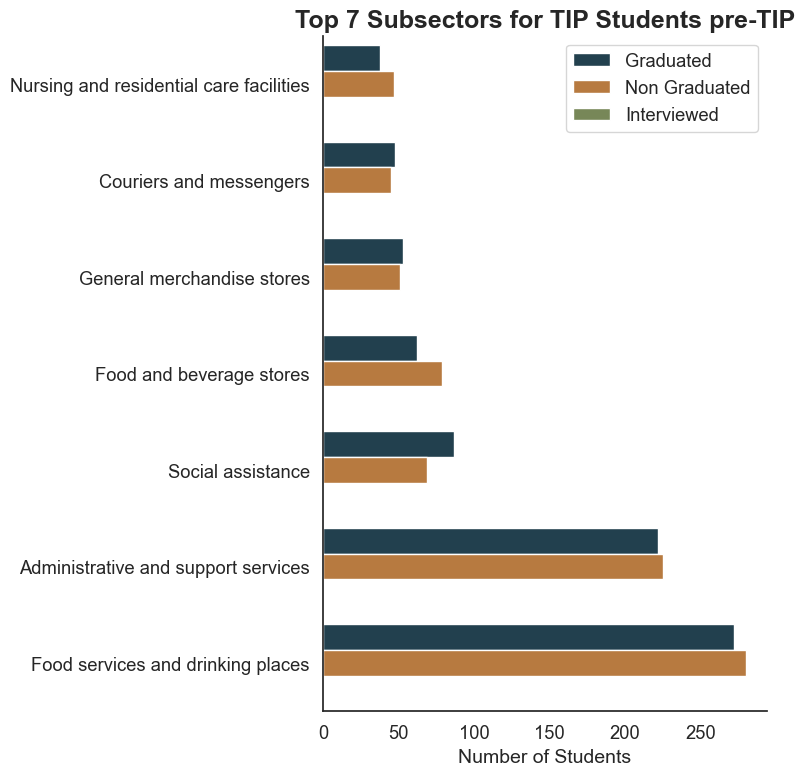

In [899]:
# 1) join StartDate + Status
e = df_earnings.merge(
    df[["tip_id", "StartDate", "Status"]],
    on="tip_id",
    how="left"
)

# 2) keep only Grad / Non Grad + pre-TIP quarters + non-missing subsector
e = e[
    e["Status"].isin(["Graduated", "Non Graduated"]) &
    (e["year_quarter_dt"] < e["StartDate"]) &
    e["naics_subsector_2017"].notna()
].copy()

# (optional) drop blank strings just in case
e = e[e["naics_subsector_2017"].astype(str).str.strip() != ""]

# 3) count unique students (tip_id) by subsector and status
counts = (
    e.groupby(["naics_subsector_2017", "Status"])["tip_id"]
    .nunique()
    .reset_index(name="count")
)

# 4) pick overall top 7 subsectors by total students (across both statuses)
top7 = (
    counts.groupby("naics_subsector_2017")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

plot_df = counts[counts["naics_subsector_2017"].isin(top7)].copy()

# order y-axis by total (top to bottom)
order = (
    plot_df.groupby("naics_subsector_2017")["count"]
    .sum()
    .sort_values(ascending=True)   # ascending so biggest ends up on top after barh
    .index
)

# 5) plot
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    data=plot_df,
    y="naics_subsector_2017",
    x="count",
    hue="Status",
    order=order,
    orient="h"
)

sns.despine()
plt.title("Top 7 Subsectors for TIP Students pre-TIP", fontdict={"fontsize": 18, "fontweight": "semibold"})
plt.xlabel("Number of Students", fontdict={"fontsize": 14})
plt.ylabel("")

# make legend look like screenshot order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title=None, loc="upper right")

plt.tight_layout()
plt.show()


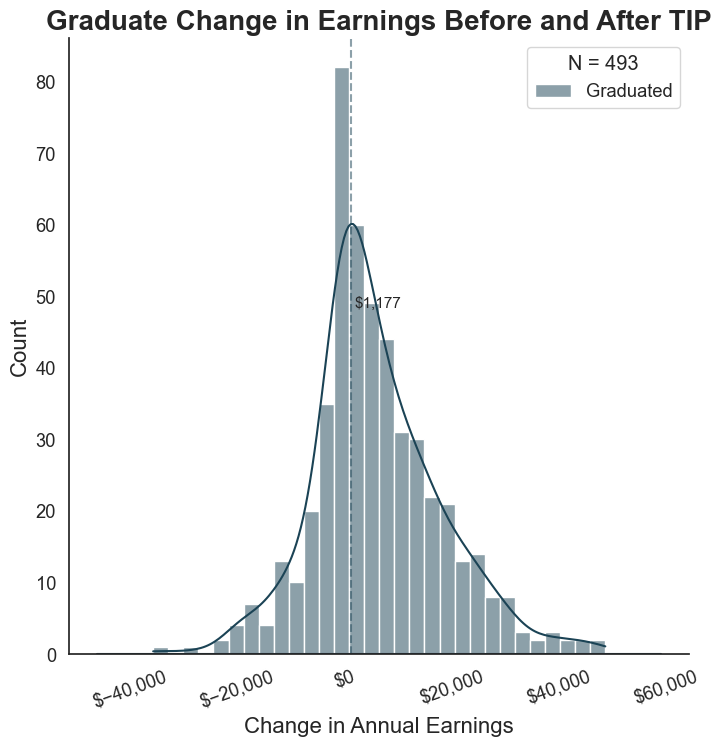

In [900]:
# 0) merge Status + StartDate onto df_earnings
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status"]],
    on="tip_id",
    how="left"
)

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Graduated: annual sum -> mean across years
pre_grad = (
    pre_tip[pre_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_grad = (
    post_tip[post_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
grad_comparison = pre_grad.merge(post_grad, on="tip_id", how="inner")
grad_comparison["delta"] = grad_comparison["adjusted_earnings_post"] - grad_comparison["adjusted_earnings_pre"]

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Graduated"
)

# KDE peak
kde = sns.kdeplot(data=grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Graduate Change in Earnings Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {grad_comparison.shape[0]}")
plt.show()


In [901]:
grad_comparison.describe()

,tip_id,adjusted_earnings_pre,adjusted_earnings_post,delta
count,493.000000,493.000000,493.000000,493.000000
mean,1338.941176,7151.840646,13176.106566,6024.265920
std,494.751016,8872.875939,12152.934509,12000.897535
min,10.000000,0.000000,0.000000,-35770.289219
25%,900.000000,761.494536,3399.954918,-573.627959
50%,1346.000000,4060.295138,10201.423254,3957.692388
75%,1764.000000,9500.189012,19376.701962,12583.157668
max,2230.000000,51061.048489,74800.471165,48741.619784


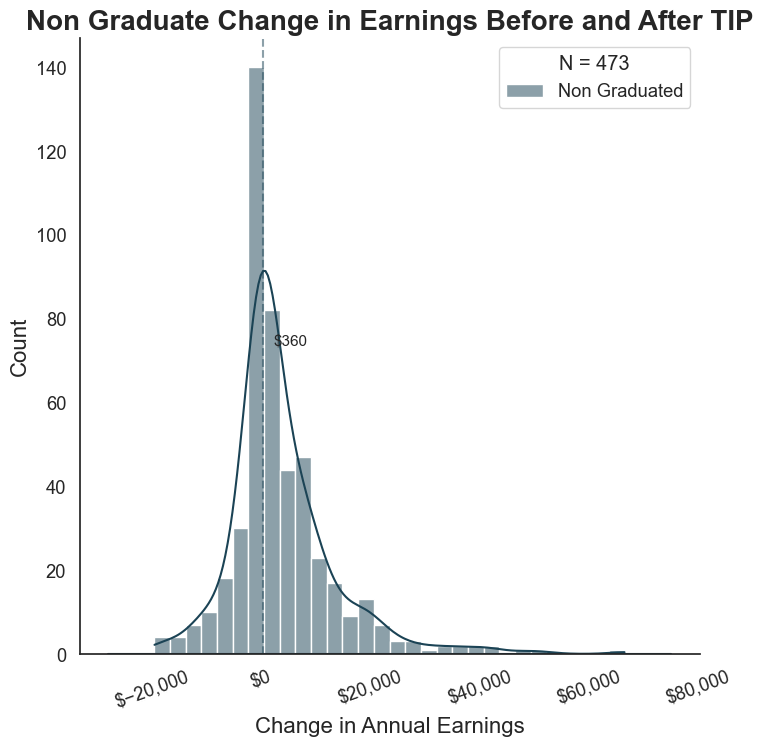

In [902]:
# 0) merge Status + StartDate onto df_earnings (if you already have earn, skip this)
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status"]],
    on="tip_id",
    how="left"
)

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Non Graduated: annual sum -> mean across years
pre_non = (
    pre_tip[pre_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_non = (
    post_tip[post_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
non_grad_comparison = pre_non.merge(post_non, on="tip_id", how="inner")
non_grad_comparison["delta"] = (
    non_grad_comparison["adjusted_earnings_post"] - non_grad_comparison["adjusted_earnings_pre"]
)

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=non_grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Non Graduated"
)

# KDE peak
kde = sns.kdeplot(data=non_grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Non Graduate Change in Earnings Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {non_grad_comparison.shape[0]}")
plt.show()


In [903]:
non_grad_comparison.describe()

,tip_id,adjusted_earnings_pre,adjusted_earnings_post,delta
count,473.000000,473.000000,473.000000,473.000000
mean,1336.329810,5201.544745,9025.671400,3824.126655
std,484.214191,8005.508430,12449.345488,9796.357824
min,1.000000,0.000000,0.000000,-19541.869471
25%,970.000000,337.094534,740.105145,-730.781156
50%,1339.000000,2310.724159,4605.430145,1292.339455
75%,1682.000000,6919.847164,11971.841381,7290.259426
max,2269.000000,79441.863951,130842.556738,66555.612829


## Data Cleaning of tip_cohort_uibenefits and Social Service Usage

In [904]:
df_uibenefits = pd.read_csv('tip_cohort_uibenefits.csv')

In [905]:
df_uibenefits.head()

,Unnamed: 0,TIP_ID,REQUEST_PERIOD,UC_BENEFIT
0,1,1189,20173,2496.0
1,2,297,20173,1648.0
2,3,663,20172,484.0
3,4,34,20172,1281.0
4,5,129,20172,2320.0


In [906]:
# 1) rename TIP_ID -> tip_id
df_uibenefits = df_uibenefits.rename(columns={"TIP_ID": "tip_id"})

# 2) create quarter (numeric) from REQUEST_PERIOD
#    REQUEST_PERIOD should look like 20181, 20174, etc.
df_uibenefits["quarter"] = pd.to_numeric(df_uibenefits["REQUEST_PERIOD"], errors="coerce")

# 3) split quarter into q_num and year
df_uibenefits["q_num"] = (df_uibenefits["quarter"] % 10).astype("Int64")
df_uibenefits["year"] = (df_uibenefits["quarter"] // 10).astype("Int64")

# 4) ui_dummy: if UC_BENEFIT not missing -> 1 else 0
df_uibenefits["ui_dummy"] = (~df_uibenefits["UC_BENEFIT"].isna()).astype(int)

# 5) annualize: if any quarter in that year has ui_dummy==1 -> employed that year for UI receipt
df_ui_annual = (
    df_uibenefits.groupby(["tip_id", "year"], as_index=False)["ui_dummy"]
    .max()
)

In [907]:
df_ui_annual.head()

,tip_id,year,ui_dummy
0,1,2017,0
1,1,2018,0
2,1,2019,0
3,1,2020,0
4,1,2021,0


In [908]:
df_services = pd.read_csv('tip_cohort_human_services_activity.csv')
df_services = pd.merge(
    df_services,
    df[['tip_id', 'Status', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate']],
    on='tip_id',
    how='left'
)

df_services['DOF'] = pd.to_datetime(df_services['year'], format='%Y')
df_services['YearsSinceTIP'] = df_services.apply(years_since_TIP, axis=1)

In [909]:
df_services.head()

,Unnamed: 0,tip_id,year,aging,drug_alcohol,mental_health,cyf_child,cyf_parent,family_support_center,early_childhood,...,tanf,ssi,ccdf,Status,StartDate,InterviewedDate,EndDate,GraduatedDate,DOF,YearsSinceTIP
0,1,632,2011,0,0,0,0,0,0,0,...,0,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2011-01-01,-6.770844
1,2,632,2012,0,0,0,0,0,0,0,...,0,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2012-01-01,-5.771508
2,3,632,2013,0,0,0,0,0,0,0,...,0,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2013-01-01,-4.769434
3,4,632,2014,0,0,0,0,0,0,0,...,0,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2014-01-01,-3.770098
4,5,632,2015,0,0,0,0,0,0,0,...,0,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,2015-01-01,-2.770762


In [910]:
df.columns

Index(['tip_id', 'GraduatedDate', 'InterviewedDate', 'StartDate', 'EndDate',
       'DriversLicense', 'Course', 'CreatedDate', 'Status', 'age',
       'cohort_2022', 'StartYear', 'census_tract', 'gender', 'race',
       'ValidYears', 'OffenseBeforeStart', 'ArrestBeforeStart', 'earnings_pre',
       'earnings_post', 'abs_change', 'per_change', 'has_employment'],
      dtype='object')

In [911]:
# 1) year -> numeric
# -------------------------
df_services["year"] = pd.to_numeric(df_services["year"], errors="coerce")

# -------------------------
# 2) SNAP_TANF = snap + tanf
#    (treat NaN as 0 so 1+NaN -> 1 rather than NaN)
# -------------------------
df_services["SNAP_TANF"] = df_services["snap"].fillna(0) + df_services["tanf"].fillna(0)

# -------------------------
# 3) Join annual UI benefits data by tip_id, year
#    Assumes you have a df_ui_annual with columns: tip_id, year, ui (0/1) or ui_amount
# -------------------------
df_services = df_services.merge(
    df_ui_annual,   # <-- change this variable name if yours is different
    on=["tip_id", "year"],
    how="left"
)

# -------------------------
# 4) Join StartYear + Participant_Type from TIP_df and compute distance_from_TIP
#    distance_from_TIP = year - StartYear
# -------------------------
df_services = df_services.merge(
    df[["tip_id", "StartYear"]],
    on="tip_id",
    how="left"
)

df_services["distance_from_TIP"] = df_services["year"] - df_services["StartYear"]

# -------------------------
# 5) any_one: received ANY listed service that year
#    treat NaN as 0; "==1" rule per your spec
# -------------------------
service_cols = [
    "aging",
    "drug_alcohol",
    "mental_health",
    "family_support_center",
    "early_childhood",
    "jail_collab",
    "matp",
    "home_visiting",
    "dhs_housing_supports",
    "indep_living",
    "intellectual_disab",
    "link_referral",
    "public_housing",
    "section8_housing",
    "medicaid",
    "snap",
    "tanf",
    "ssi",
    "ccdf",
]

# coerce to numeric (in case of strings), fill NaN with 0
svc_mat = df_services[service_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

df_services["any_one"] = (svc_mat.eq(1).any(axis=1)).astype(int)

# -------------------------
# 6) any_one_plus_ui: include UI receipt as well
#    Pick the UI indicator column name after merge.
#    - If your df_ui_annual column is called "ui", this will work as-is.
#    - Otherwise change ui_col below to your actual column name.
# -------------------------
ui_col = "ui_dummy"  # <-- change if needed (e.g., "ui_receipt", "received_ui", etc.)

df_services[ui_col] = pd.to_numeric(df_services[ui_col], errors="coerce").fillna(0)
df_services["any_one_plus_ui"] = ((df_services["any_one"] == 1) | (df_services[ui_col] == 1)).astype(int)


In [912]:
df_services = df_services.drop(columns=["Unnamed: 0"], errors="ignore")
df_services.head()

,tip_id,year,aging,drug_alcohol,mental_health,cyf_child,cyf_parent,family_support_center,early_childhood,jail_collab,...,EndDate,GraduatedDate,DOF,YearsSinceTIP,SNAP_TANF,ui_dummy,StartYear,distance_from_TIP,any_one,any_one_plus_ui
0,632,2011,0,0,0,0,0,0,0,0,...,2017-12-07,NaT,2011-01-01,-6.770844,0,0.0,2017.0,-6.0,1,1
1,632,2012,0,0,0,0,0,0,0,0,...,2017-12-07,NaT,2012-01-01,-5.771508,0,0.0,2017.0,-5.0,1,1
2,632,2013,0,0,0,0,0,0,0,0,...,2017-12-07,NaT,2013-01-01,-4.769434,0,0.0,2017.0,-4.0,1,1
3,632,2014,0,0,0,0,0,0,0,0,...,2017-12-07,NaT,2014-01-01,-3.770098,0,0.0,2017.0,-3.0,1,1
4,632,2015,0,0,0,0,0,0,0,0,...,2017-12-07,NaT,2015-01-01,-2.770762,0,0.0,2017.0,-2.0,1,1


In [914]:
df_services.columns

Index(['tip_id', 'year', 'aging', 'drug_alcohol', 'mental_health', 'cyf_child',
       'cyf_parent', 'family_support_center', 'early_childhood', 'jail_collab',
       'matp', 'home_visiting', 'dhs_housing_supports', 'indep_living',
       'intellectual_disab', 'cyf_referral', 'link_referral', 'public_housing',
       'section8_housing', 'courts', 'medicaid', 'jail', 'snap', 'tanf', 'ssi',
       'ccdf', 'Status', 'StartDate', 'InterviewedDate', 'EndDate',
       'GraduatedDate', 'DOF', 'YearsSinceTIP', 'SNAP_TANF', 'ui_dummy',
       'StartYear', 'distance_from_TIP', 'any_one', 'any_one_plus_ui'],
      dtype='object')

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3952332178.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  denom = df[df["Status"].isin(STATUSES)].groupby("Status")["tip_id"].nunique().to_dict()


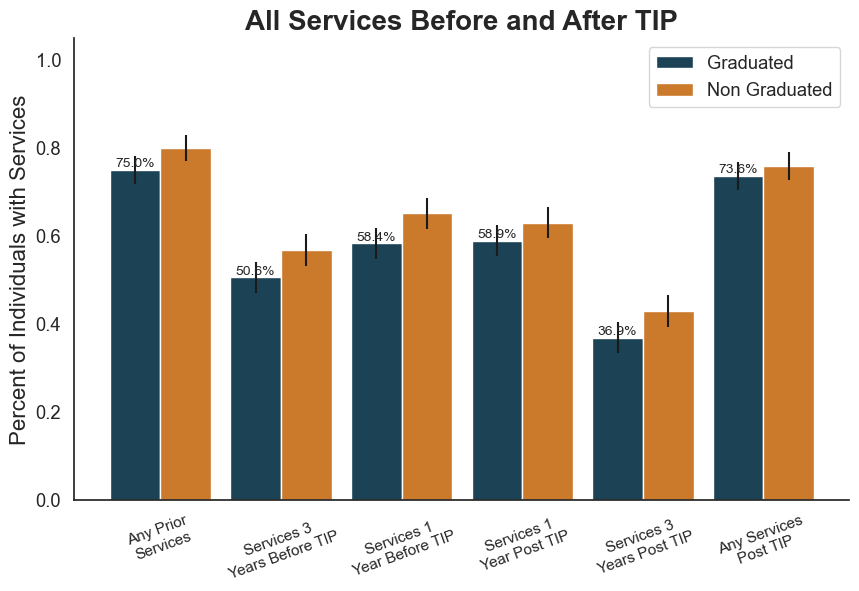

In [915]:
# ================
# CONFIG
# ================
STATUSES = ["Graduated", "Non Graduated"]
z = 1.96

# pick a clean Status col (your df_services has Status_x / Status_y)
status_col = "Status"

svc = df_services.copy()
svc = svc[svc[status_col].isin(STATUSES)].copy()

# denominators (all TIP people by status, from df)
denom = df[df["Status"].isin(STATUSES)].groupby("Status")["tip_id"].nunique().to_dict()

def pct_ci(num, denom_):
    if denom_ <= 0:
        return 0.0, np.nan, np.nan
    p = num / denom_
    se = np.sqrt(p * (1 - p) / denom_)
    return p, max(0, p - z * se), min(1, p + z * se)

# ================
# 1) Define categories exactly like the figure
# ================
# NOTE: Uses "at least one service used" within the window (any_one==1 on any row in window)
categories = [
    ("Any Prior\nServices", "any_prior"),
    ("Services 3\nYears Before TIP", "pre_3y"),
    ("Services 1\nYear Before TIP", "pre_1y"),
    ("Services 1\nYear Post TIP", "post_1y"),
    ("Services 3\nYears Post TIP", "post_3y"),
    ("Any Services\nPost TIP", "any_post"),
]

rows = []
for status in STATUSES:
    denom_any = denom.get(status, 0)

    for label, key in categories:
        if key == "any_prior":
            # any year before TIP (distance_from_TIP < 0) with any_one==1
            num = svc.loc[
                (svc[status_col] == status) &
                (svc["distance_from_TIP"] < 0) &
                (svc["any_one"] == 1),
                "tip_id"
            ].nunique()
            denom_ = denom_any

        elif key == "pre_3y":
            # exactly 3 years before TIP (distance == -3) with any_one==1
            num = svc.loc[
                (svc[status_col] == status) &
                (svc["distance_from_TIP"] == -3) &
                (svc["any_one"] == 1),
                "tip_id"
            ].nunique()
            denom_ = denom_any

        elif key == "pre_1y":
            # exactly 1 year before TIP (distance == -1)
            num = svc.loc[
                (svc[status_col] == status) &
                (svc["distance_from_TIP"] == -1) &
                (svc["any_one"] == 1),
                "tip_id"
            ].nunique()
            denom_ = denom_any

        elif key == "post_1y":
            # exactly 1 year post TIP (distance == 1)
            num = svc.loc[
                (svc[status_col] == status) &
                (svc["distance_from_TIP"] == 1) &
                (svc["any_one"] == 1),
                "tip_id"
            ].nunique()
            denom_ = denom_any

        elif key == "post_3y":
            # exactly 3 years post TIP (distance == 3)
            num = svc.loc[
                (svc[status_col] == status) &
                (svc["distance_from_TIP"] == 3) &
                (svc["any_one"] == 1),
                "tip_id"
            ].nunique()
            denom_ = denom_any

        elif key == "any_post":
            # any year after TIP (distance_from_TIP > 0)
            num = svc.loc[
                (svc[status_col] == status) &
                (svc["distance_from_TIP"] > 0) &
                (svc["any_one"] == 1),
                "tip_id"
            ].nunique()
            denom_ = denom_any

        p, lo, hi = pct_ci(num, denom_)
        rows.append({
            "Category": label,
            "Status": status,
            "Percent": p,
            "Lower": lo,
            "Upper": hi
        })

plot_df = pd.DataFrame(rows)
plot_df["Status"] = pd.Categorical(plot_df["Status"], categories=STATUSES, ordered=True)
plot_df["Category"] = pd.Categorical(plot_df["Category"], categories=[c[0] for c in categories], ordered=True)
plot_df = plot_df.sort_values(["Category", "Status"]).reset_index(drop=True)

# reshape for yerr
pivot = plot_df.pivot(index="Category", columns="Status", values="Percent")
upper = plot_df.pivot(index="Category", columns="Status", values="Upper")
lower = plot_df.pivot(index="Category", columns="Status", values="Lower")

grad_err = np.abs(np.vstack([upper["Graduated"].values, lower["Graduated"].values]) - pivot["Graduated"].values)
nongrad_err = np.abs(np.vstack([upper["Non Graduated"].values, lower["Non Graduated"].values]) - pivot["Non Graduated"].values)

# ================
# 2) Plot
# ================
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(pivot.index))
width = 0.42

ax.bar(
    x - width/2,
    pivot["Graduated"].values,
    width=width,
    label="Graduated",
    yerr=grad_err,
    capsize=0
)
ax.bar(
    x + width/2,
    pivot["Non Graduated"].values,
    width=width,
    label="Non Graduated",
    yerr=nongrad_err,
    capsize=0
)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index.tolist(), rotation=20, ha="center", fontsize=11)

# label Graduated bars (like your screenshot)
for xi, yi in zip(x - width/2, pivot["Graduated"].values):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("All Services Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Services", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()
